In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

file_path = "/content/drive/MyDrive/games.csv"
df = pd.read_csv(file_path)

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB


,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


# Обработка данных

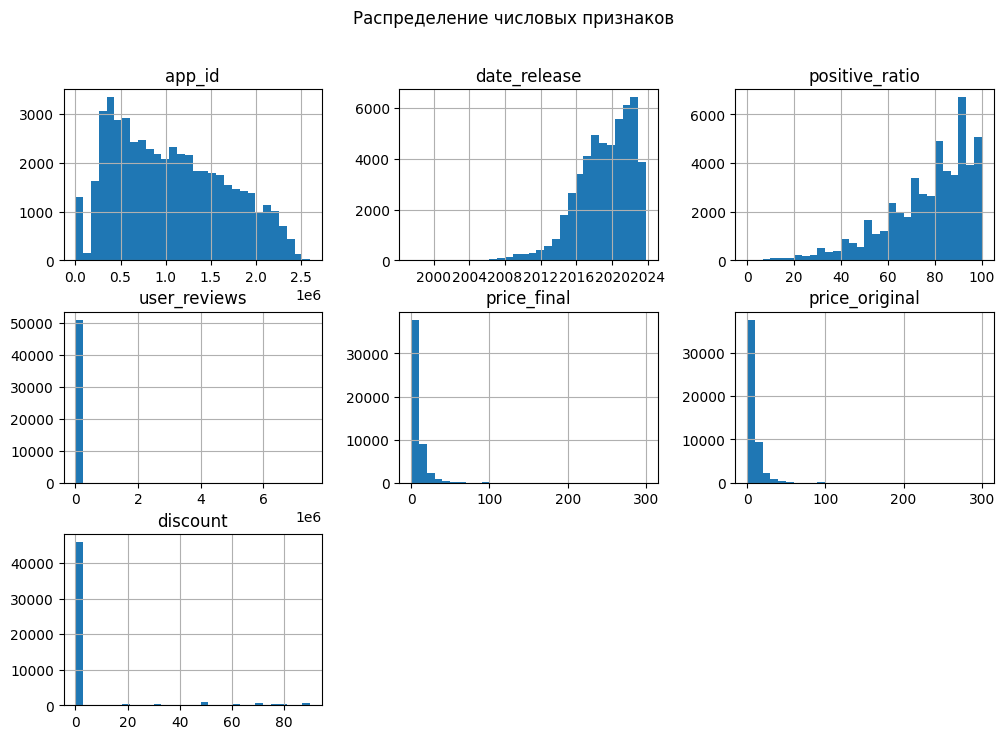

app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64


In [47]:
df["date_release"] = pd.to_datetime(df["date_release"], errors="coerce")


missing_values = df.isnull().sum()


df.hist(figsize=(12, 8), bins=30)
plt.suptitle("Распределение числовых признаков")
plt.show()


print(missing_values)

In [48]:
q_low = df["user_reviews"].quantile(0.01)
q_high = df["user_reviews"].quantile(0.99)
df = df[(df["user_reviews"] >= q_low) & (df["user_reviews"] <= q_high)]

q_low = df["price_final"].quantile(0.01)
q_high = df["price_final"].quantile(0.99)
df = df[(df["price_final"] >= q_low) & (df["price_final"] <= q_high)]


df["rating"] = df["rating"].astype("category").cat.codes


df["years_since_release"] = (pd.to_datetime("today") - df["date_release"]).dt.days // 365


df.drop(columns=["app_id", "title", "date_release"], inplace=True)


df.head()

,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,years_since_release
0,True,False,False,8,84,2199,9.99,9.99,0.0,True,16
1,True,False,False,6,85,21,2.99,2.99,0.0,True,13
2,True,True,True,8,92,3722,14.99,14.99,0.0,True,11
3,True,False,False,0,61,873,14.99,14.99,0.0,True,10
4,True,True,False,8,88,8784,11.99,11.99,0.0,True,10


# Реализация baseline-решения

In [ ]:
def baseline_clustering(df):
    conditions = [
        (df["price_final"] > 20),
        (df["user_reviews"] > 1000),
        (df["rating"] > 2)
    ]
    choices = [0, 1, 2]
    return np.select(conditions, choices, default=3)

# Метод локтя (подбор гиперпараметров)

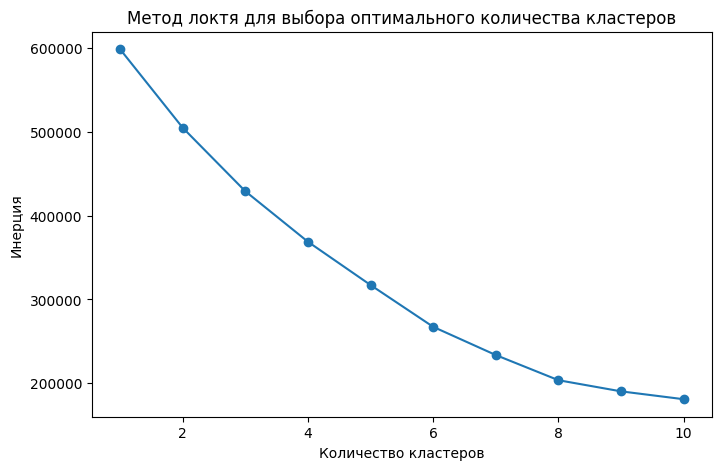

In [65]:
def plot_elbow_method(data, max_clusters=10):
    inertia = []
    cluster_range = range(1, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, inertia, marker="o", linestyle="-")
    plt.xlabel("Количество кластеров")
    plt.ylabel("Инерция")
    plt.title("Метод локтя для выбора оптимального количества кластеров")
    plt.show()


plot_elbow_method(df_scaled, max_clusters=10)

# Обучение модели (K-means)

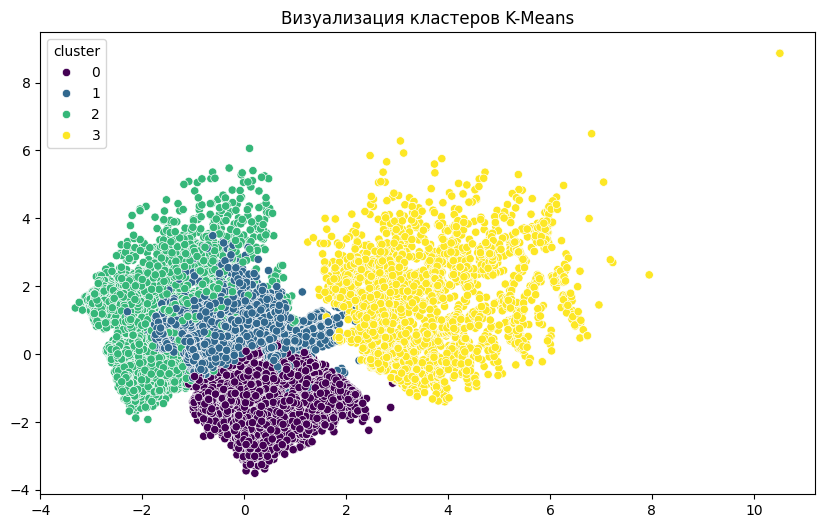

In [59]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(df_scaled)


pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df["cluster"], palette="viridis")
plt.title("Визуализация кластеров K-Means")
plt.show()

# Обучение модели (DBSCAN)

In [61]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
df["dbscan_cluster"] = dbscan.fit_predict(df_scaled)


if len(set(df["dbscan_cluster"])) > 1:
    silhouette_dbscan = silhouette_score(df_scaled, df["dbscan_cluster"])
    print(f"Силуэтный коэффициент для DBSCAN: {silhouette_dbscan:.4f}")
else:
    print("DBSCAN нашел только один кластер или пометил все как выбросы.")

Силуэтный коэффициент для DBSCAN: 0.1931


# Реализация CustomKMeans

In [62]:
class CustomKMeans:
    def __init__(self, n_clusters=4, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        np.random.seed(42)
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels = np.argmin(distances, axis=1)

            new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.n_clusters)])
            if np.linalg.norm(self.centroids - new_centroids) < self.tol:
                break
            self.centroids = new_centroids

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)


custom_kmeans = CustomKMeans(n_clusters=4)
custom_kmeans.fit(df_scaled)
df["custom_cluster"] = custom_kmeans.predict(df_scaled)

# Сравнение качества моделей

In [67]:
silhouette_custom = silhouette_score(df_scaled, df["custom_cluster"])
print(f"Силуэтный коэффициент для кастомного K-Means: {silhouette_custom:.4f}")

silhouette_kmeans = silhouette_score(df_scaled, df["cluster"])
print(f"Силуэтный коэффициент для K-Means: {silhouette_kmeans:.4f}")

df["baseline_cluster"] = baseline_clustering(df)


silhouette_baseline = silhouette_score(df_scaled, df["baseline_cluster"])
print(f"Силуэтный коэффициент baseline: {silhouette_baseline:.4f}")

Силуэтный коэффициент для кастомного K-Means: 0.2503
Силуэтный коэффициент для K-Means: 0.2833
Силуэтный коэффициент baseline: 0.1884
